In [50]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# 12by12 Unimanual Representation

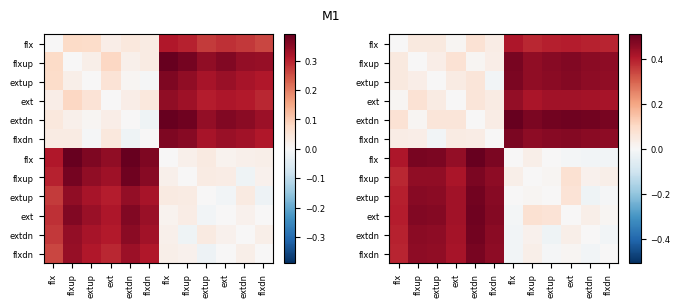

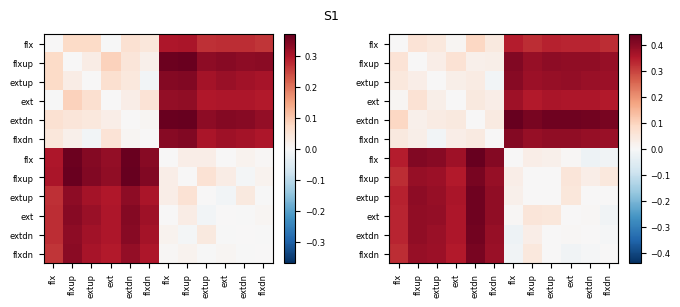

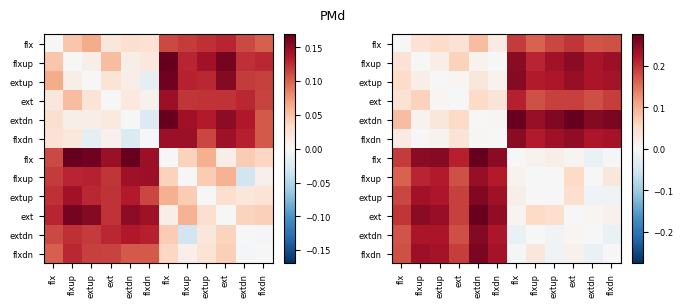

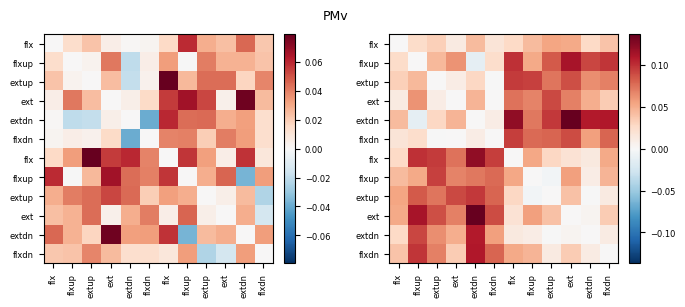

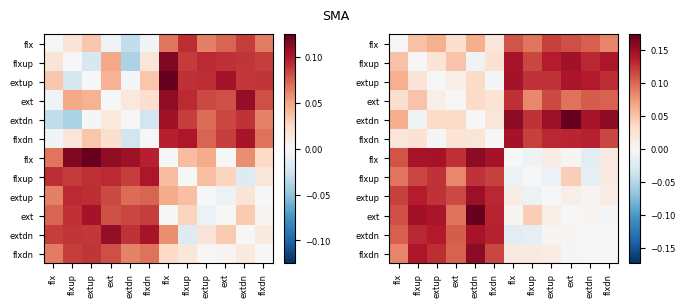

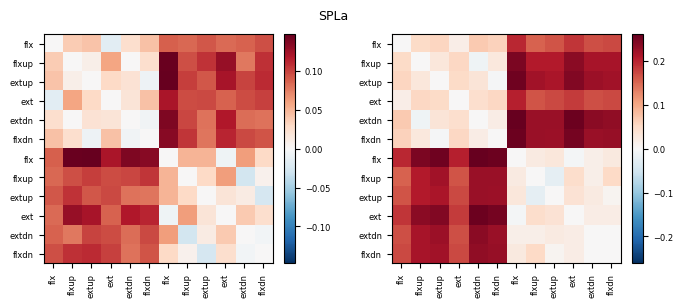

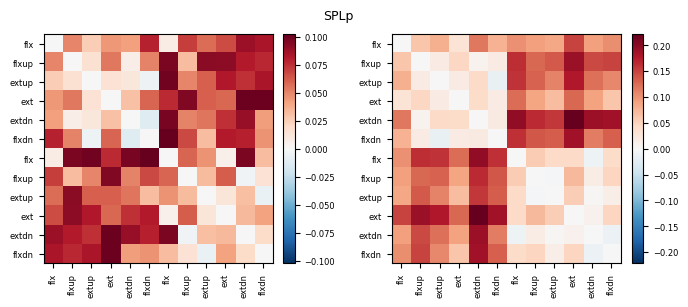

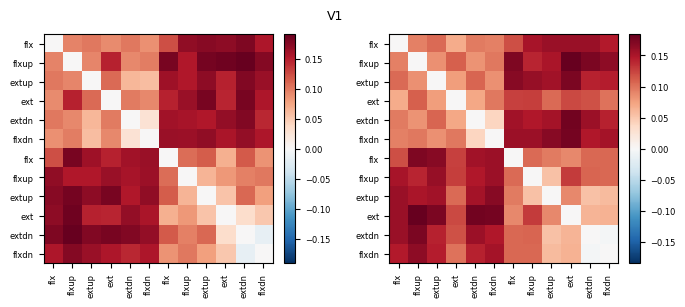

In [146]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']

RDMs_unimanual = {'sn': [], 'region':[], 'hem':[], 'labels': [], 'G': [], 'D^2': []}

for i_region, region in enumerate(regions):
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)
        data, cond_vec, part_vec = [], [], []

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            Y = data_tmp[i_sub][idx, :]
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
        N = len(Y)
        ncond = 12
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
            RDMs_unimanual['sn'].append(subject[i_sub])
            RDMs_unimanual['region'].append(region)
            RDMs_unimanual['hem'].append(h)
            RDMs_unimanual['labels'].append(labels)
            RDMs_unimanual['G'].append(G_hat[i_sub, :, :])
            dist = pcm.G_to_dist(G_hat[i_sub, :, :])
            RDMs_unimanual['D^2'].append(dist)

RDMs_unimanual = pd.DataFrame(RDMs_unimanual)
RDMs_unimanual.to_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))

# PLOT:
plt.rcParams.update({'font.size': 6})
cmap = 'RdBu_r'
for region in regions:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_L = np.mean(D, axis=0)

    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_R = np.mean(D, axis=0)

    fig, ax = plt.subplots(1,2, figsize=(7,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, d in enumerate([D_avg_L, D_avg_R]):
        plt.sca(ax[i])
        vmin = -np.max(np.abs(d))
        vmax = np.max(np.abs(d))
        im = ax[i].imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ax[i].set_xticks(np.arange(len(labels)))
        ax[i].set_yticks(np.arange(len(labels)))
        ax[i].set_xticklabels(labels)
        ax[i].set_yticklabels(labels)
        ax[i].set_xticks(list(range(len(labels))))
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_yticks(list(range(len(labels))))
        ax[i].set_yticklabels(labels)

    plt.tight_layout()
    plt.show()



# Is the sturcture similar across hemisphere?

M1 within:
    contra-contra: t=4.25, p=0.0003
    contra-ipsi: t=-3.29, p=0.0032
    ipsi-ipsi: t=0.64, p=0.5283
    ipsi-contra: t=-1.81, p=0.0830
M1 between:
    contra-contra: t=5.49, p=0.0000
    contra-ipsi: t=-3.16, p=0.0044
    ipsi-ipsi: t=1.54, p=0.1384
    ipsi-contra: t=-1.70, p=0.1034


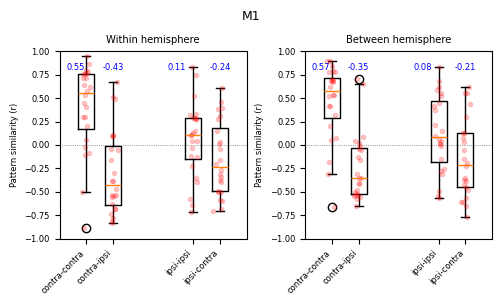

S1 within:
    contra-contra: t=3.87, p=0.0008
    contra-ipsi: t=-1.64, p=0.1147
    ipsi-ipsi: t=-0.10, p=0.9193
    ipsi-contra: t=-1.21, p=0.2399
S1 between:
    contra-contra: t=4.71, p=0.0001
    contra-ipsi: t=-1.04, p=0.3105
    ipsi-ipsi: t=0.97, p=0.3404
    ipsi-contra: t=-0.99, p=0.3308


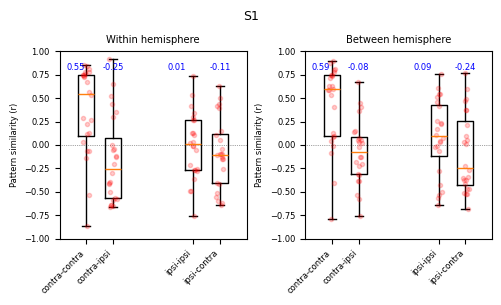

PMd within:
    contra-contra: t=3.99, p=0.0006
    contra-ipsi: t=-2.24, p=0.0350
    ipsi-ipsi: t=3.08, p=0.0053
    ipsi-contra: t=-1.68, p=0.1059
PMd between:
    contra-contra: t=5.25, p=0.0000
    contra-ipsi: t=-3.74, p=0.0011
    ipsi-ipsi: t=3.20, p=0.0039
    ipsi-contra: t=-2.79, p=0.0104


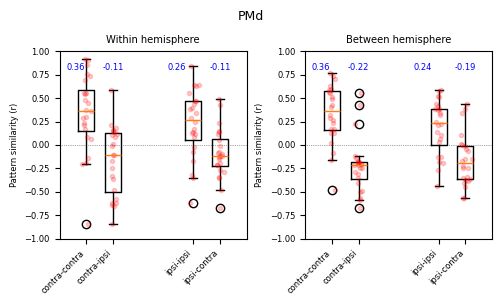

PMv within:
    contra-contra: t=2.41, p=0.0246
    contra-ipsi: t=-0.61, p=0.5509
    ipsi-ipsi: t=1.37, p=0.1831
    ipsi-contra: t=0.84, p=0.4079
PMv between:
    contra-contra: t=0.73, p=0.4753
    contra-ipsi: t=1.83, p=0.0802
    ipsi-ipsi: t=0.67, p=0.5065
    ipsi-contra: t=1.68, p=0.1056


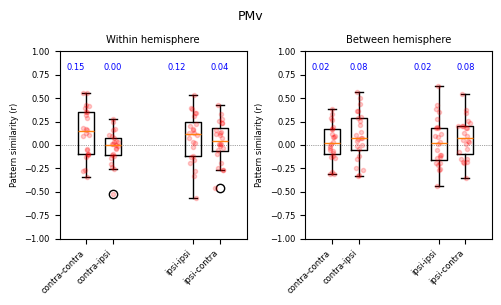

SMA within:
    contra-contra: t=3.20, p=0.0040
    contra-ipsi: t=-1.61, p=0.1202
    ipsi-ipsi: t=2.45, p=0.0222
    ipsi-contra: t=-0.75, p=0.4617
SMA between:
    contra-contra: t=3.86, p=0.0008
    contra-ipsi: t=-0.20, p=0.8426
    ipsi-ipsi: t=0.49, p=0.6281
    ipsi-contra: t=0.87, p=0.3953


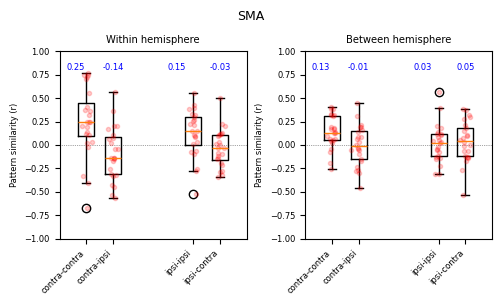

SPLa within:
    contra-contra: t=2.93, p=0.0076
    contra-ipsi: t=-1.30, p=0.2048
    ipsi-ipsi: t=2.22, p=0.0366
    ipsi-contra: t=-0.32, p=0.7531
SPLa between:
    contra-contra: t=3.65, p=0.0013
    contra-ipsi: t=-1.79, p=0.0874
    ipsi-ipsi: t=4.37, p=0.0002
    ipsi-contra: t=-2.04, p=0.0531


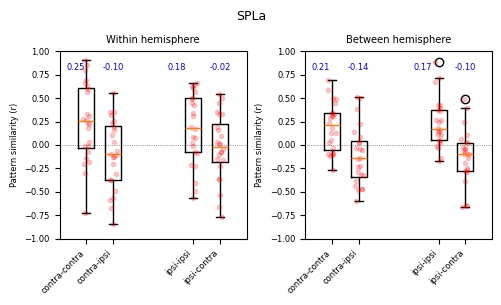

SPLp within:
    contra-contra: t=2.88, p=0.0085
    contra-ipsi: t=-0.19, p=0.8504
    ipsi-ipsi: t=3.19, p=0.0041
    ipsi-contra: t=1.19, p=0.2469
SPLp between:
    contra-contra: t=2.07, p=0.0497
    contra-ipsi: t=1.80, p=0.0848
    ipsi-ipsi: t=3.85, p=0.0008
    ipsi-contra: t=1.02, p=0.3179


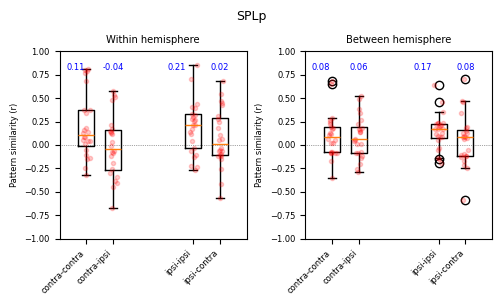

V1 within:
    contra-contra: t=11.84, p=0.0000
    contra-ipsi: t=13.01, p=0.0000
    ipsi-ipsi: t=8.38, p=0.0000
    ipsi-contra: t=4.35, p=0.0002
V1 between:
    contra-contra: t=10.31, p=0.0000
    contra-ipsi: t=14.71, p=0.0000
    ipsi-ipsi: t=7.63, p=0.0000
    ipsi-contra: t=6.87, p=0.0000


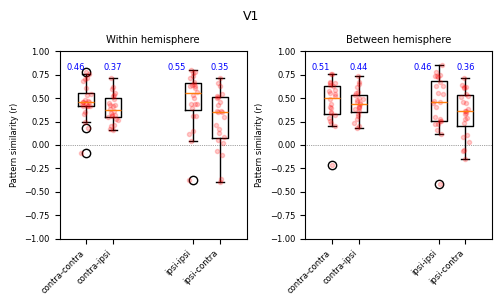

In [ ]:
df = {'region': [], 'hem': [], 'within_hem': [], 'sn': [], 'r_contra_contra': [], 'r_ipsi_ipsi': [], 'r_contra_ipsi': [], 'r_ipsi_contra': []}

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']
for region in regions:
    # # ============================= Within Hem =============================
    for i, h in enumerate(hem):
        tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']==h)]
        G = tmp['G'].to_list()
        G = np.array(G)
        # N-1 cross validation:
        N = np.shape(G)[0]
        r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
        for i in range(N):
            G_mean = np.mean(np.delete(G, i, axis=0), axis=0)
            # G_mean = pcm.G_to_dist(G_mean)
            G_sub = G[i, :, :]
            # G_sub = pcm.G_to_dist(G_sub)

            # imshow of G_mean and G_sub with subplots(1,2):
            # if region == 'V1':
            #     cmap = 'RdBu_r'
            #     fig, ax = plt.subplots(1,2, figsize=(3.5,2))
            #     vmin = -np.max(np.abs(G_sub))
            #     vmax = np.max(np.abs(G_sub))
            #     ax[0].imshow(G_sub, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[0].set_title('G_sub')
            #     vmin = -np.max(np.abs(G_mean))
            #     vmax = np.max(np.abs(G_mean))
            #     ax[1].imshow(G_mean, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[1].set_title('G_mean')
            #     plt.suptitle(f'sn {tmp["sn"].values[i]} - {region}_{h}', fontsize=9)
            #     plt.tight_layout()
            #     plt.show()

            # contra-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[:6, :6]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_contra_contra.append(r)

            # ipsi-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[6:, 6:]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_ipsi_ipsi.append(r)

            # contra-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[:6, :6]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_contra_ipsi.append(r)

            # ipsi-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[6:, 6:]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_ipsi_contra.append(r)

        df['region'].append(region)
        df['hem'].append(f'{h}2{h}')
        df['within_hem'].append('within')
        df['sn'].append(list(tmp['sn']))
        df['r_contra_contra'].append(r_contra_contra)
        df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
        df['r_contra_ipsi'].append(r_contra_ipsi)
        df['r_ipsi_contra'].append(r_ipsi_contra)
    
    # Between Hemisphere Correlation:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    G_L = tmp['G'].to_list()
    G_L = np.array(G_L)
    
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    G_R = tmp['G'].to_list()
    G_R = np.array(G_R)

    # ============================= L to R =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_R = np.mean(np.delete(G_R, i, axis=0), axis=0)
        # G_mean_R = pcm.G_to_dist(G_mean_R)
        G_sub_L = G_L[i, :, :]
        # G_sub_L = pcm.G_to_dist(G_sub_L)

        # contra-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('L2R')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)

    # ============================= R to L =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_L = np.mean(np.delete(G_L, i, axis=0), axis=0)
        # G_mean_L = pcm.G_to_dist(G_mean_L)
        G_sub_R = G_R[i, :, :]
        # G_sub_R = pcm.G_to_dist(G_sub_R)

        # contra-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('R2L')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)
df = pd.DataFrame(df)

# PLOT:
# In one box plot:
# First within hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
# Then between hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
plt.rcParams.update({'font.size': 6})
for region in regions:
    fig, ax = plt.subplots(1,2, figsize=(5,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, wh in enumerate(['within', 'between']):
        plt.sca(ax[i])
        tmp = df[(df['region']==region) & (df['within_hem']==wh)]
        r_contra_contra = tmp['r_contra_contra'].values[0] + tmp['r_contra_contra'].values[1]
        r_ipsi_ipsi = tmp['r_ipsi_ipsi'].values[0] + tmp['r_ipsi_ipsi'].values[1]
        r_contra_ipsi = tmp['r_contra_ipsi'].values[0] + tmp['r_contra_ipsi'].values[1]
        r_ipsi_contra = tmp['r_ipsi_contra'].values[0] + tmp['r_ipsi_contra'].values[1]
        data_plot = [r_contra_contra, r_contra_ipsi, r_ipsi_ipsi, r_ipsi_contra]
        ax[i].boxplot(data_plot, positions=[1,1.5,3,3.5], widths=0.3)
        ax[i].axhline(0, color='k', linestyle=':', linewidth=0.5, alpha=0.7)
        ax[i].set_xticks([1,1.5,3,3.5])
        ax[i].set_xticklabels(['contra-contra', 'contra-ipsi', 'ipsi-ipsi', 'ipsi-contra'], rotation=45, ha='right')
        ax[i].set_ylabel('Pattern similarity (r)')
        ax[i].set_ylim([-1, 1])
        ax[i].set_title(f'{wh.capitalize()} hemisphere')
        # ax[i].set_yticks(np.arange(-0.1, 1.1, 0.2))
        # individual data points:
        for j in range(len(data_plot)):
            y = data_plot[j]
            x = np.random.normal([1,1.5,3,3.5][j], 0.04, size=len(y))  # add some random "jitter" to the x-axis
            ax[i].plot(x, y, 'r.', alpha=0.2)
        # print mean values:
        for j in range(len(data_plot)):
            y = data_plot[j]
            median_val = np.median(y)
            ax[i].text([0.8,1.5,2.7,3.5][j], 0.8, f'{median_val:.2f}', ha='center', fontsize=6, color='blue')
        
        # test vs 0 for each box:
        print(f'{region} {wh}:')
        for j in range(len(data_plot)):
            y = data_plot[j]
            t, p = scipy.stats.ttest_1samp(y, 0)
            print(f'    {["contra-contra", "contra-ipsi", "ipsi-ipsi", "ipsi-contra"][j]}: t={t:.2f}, p={p:.4f}')
    plt.tight_layout()
    plt.show()

